In [1]:
import warnings
warnings.filterwarnings('ignore')
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
import sys
sys.path.append('/glade/u/home/linnia/ctsm6_ppe/')
from utils.pyfunctions import *
utils_path = '/glade/u/home/linnia/ctsm6_ppe/utils/'

2025-08-28 15:29:07.368117: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-28 15:29:09.040922: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756416549.380610   93575 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756416549.515735   93575 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-28 15:29:10.294330: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='25GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='${SCRATCH}/junk/', 
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    account='P93300041', # Input your project ID here
    walltime='01:00:00', # Amount of wall time
    #interface='ib0', # Interface to use
)

# Scale up
cluster.scale(10)

# Setup your client
client = Client(cluster)

In [42]:
def pxbmean(da):
    f='/glade/u/home/linnia/ctsm6_ppe/utils/lapxb_sg_sudoku3_ctsm53017.nc'
    lapxb=xr.open_dataset(f).lapxb_sg
    x=(lapxb*da).sum(dim=['pft','vegtype'])/(lapxb).sum(dim=['pft','vegtype'])
    xm=x.mean(dim='year')
    return x

In [43]:
def sudoku_biome_mean(ds):
    biome_masks=xr.open_dataset('~/ctsm6_ppe/biomes/sudoku_biomes_v3.nc')
    d='/glade/work/linnia/CLM6-PPE/BNF_v2.n01_ctsm5.3.012_transient_SP/run/'
    f=glob.glob(d+'*clm2.h0.*')[0]
    ds_sp=xr.open_dataset(f,decode_timedelta=False)
    
    biome_mean = ((ds_sp.area * ds_sp.landfrac * ds).groupby(biome_masks.sudoku_biomes).sum()
    / ((ds_sp.area * ds_sp.landfrac).groupby(biome_masks.sudoku_biomes).sum()))

    return biome_mean.compute()

In [44]:
biome_names=xr.open_dataset('~/ctsm6_ppe/biomes/sudoku_biomes_v3.nc').biome_names

### Load observations

In [45]:
# load observations
obs = xr.open_dataset('observational_data.nc')

### Load sparsegrid tests

In [46]:
base_path = '/glade/derecho/scratch/linnia/BNF_v2.n01_ctsm5.3.012_transient_'
#ensemble_ids = [f"caltest{str(i).zfill(4)}" for i in range(86, 91)]
ensemble_ids = ['caltest0107']

In [47]:
dvs = ['TOTVEGC','GPP','TLAI','EFLX_LH_TOT','ER','TOTSOMC_1m']

def pp(ds):
    yr0=str(ds['time.year'][0].values)
    nt=len(ds.time)
    ds['time'] = xr.cftime_range(yr0,periods=nt,freq='MS',calendar='noleap') #fix time bug
    return ds[dvs]

In [48]:
# load test ensemble

all_datasets = []

for ens_index, ens_id in enumerate(ensemble_ids):
    path = os.path.join(base_path + ens_id, 'run', '*.h0.*')
    files = sorted(glob.glob(path))
    
    if not files:
        print(f"No files found for ensemble {ens_id}")
        continue
    
    ds = xr.open_mfdataset(files[28:], preprocess=pp)
    ds = ds.expand_dims(ens=[ens_index])
    all_datasets.append(ds)

combined_ds = xr.concat(all_datasets, dim='ens')

# calculate 
lai = amax(combined_ds['TLAI']).sel(year=slice('2001','2020')).mean(dim='year')
sg_lai = get_map(lai)
gpp = (60*60*24)*amean(combined_ds['GPP']).sel(year=slice('2001','2015')).mean(dim='year')
sg_gpp = get_map(gpp)
tvc = (1/1000)*amean(combined_ds['TOTVEGC']).sel(year=slice('2000','2019')).mean(dim='year')
sg_tvc = get_map(tvc)
et=amean(combined_ds['EFLX_LH_TOT'].sel(time=slice('2000','2014'))).mean(dim='year')
sg_lh = get_map(et)

KeyboardInterrupt: 

In [ ]:
# Load h1 tape
dvs = ['TLAI','GPP','TOTVEGC','pfts1d_itype_veg']
def pp(ds):
    yr0=str(ds['time.year'][0].values)
    nt=len(ds.time)
    ds['time'] = xr.cftime_range(yr0,periods=nt,freq='MS',calendar='noleap') #fix time bug
    return ds[dvs]

# load test ensemble
all_datasets = []

for ens_index, ens_id in enumerate(ensemble_ids):
    path = os.path.join(base_path + ens_id, 'run', '*.h1.*')
    files = sorted(glob.glob(path))
    
    if not files:
        print(f"No files found for ensemble {ens_id}")
        continue
    
    ds = xr.open_mfdataset(files[28:], preprocess=pp)
    ds = ds.expand_dims(ens=[ens_index])
    all_datasets.append(ds)

combined_ds_h1 = xr.concat(all_datasets, dim='ens')


In [ ]:
#### calc biome means

yr1 = '2001'
yr2 = '2020'
v = 'TLAI'
sg_lai=amax(combined_ds_h1[v].sel(time=slice(yr1,yr2))).mean(dim='year')
TLAI_biome_amax = pxbmean(sg_lai)

yr1 = '2000'
yr2 = '2019'
sg_tvc=(1/1000)*amean(combined_ds_h1['TOTVEGC'].sel(time=slice(yr1,yr2))).mean(dim='year')
TVC_biome = pxbmean(sg_tvc) # kgC/m2

yr1 = '2001'
yr2 = '2015'
sg_gpp=(60*60*24)*amean(combined_ds_h1['GPP'].sel(time=slice(yr1,yr2))).mean(dim='year')
GPP_biome = pxbmean(sg_gpp) #gC/m2/day

# default
path = '/glade/campaign/cgd/tss/projects/PPE/ctsm6_lhc/hist/*lhc0000*.h1.*'
files=sorted(glob.glob(path))
ds_default = xr.open_mfdataset(files[28:],preprocess=pp).compute()
# calculate pxb mean
x=amax(ds_default['TLAI'].sel(time=slice('2001','2020'))).mean(dim='year')
TLAI_biome_amax_default = pxbmean(x)
TLAI_biome_amax_default = TLAI_biome_amax_default.sel(year=slice('2001','2020')).mean(dim='year')

x=amean(ds_default['GPP'].sel(time=slice('2001','2015'))).mean(dim='year')
GPP_biome_default = pxbmean(x)
GPP_biome_default = GPP_biome_default.sel(year=slice('2001','2015')).mean(dim='year')

x=amax(ds_default['TOTVEGC'].sel(time=slice('2000','2019'))).mean(dim='year')
TVC_biome_default = pxbmean(x)
TVC_biome_default = TVC_biome_default.sel(year=slice('2000','2019')).mean(dim='year')


### Load full grid CLM I-cases

In [6]:
dvs = ['TOTVEGC','FSH','GPP','TLAI','EFLX_LH_TOT','TOTSOMC_1m','BTRANMN','area','landfrac']

def pp(ds):
    return ds[dvs]

In [5]:
# load default
path = os.path.join('/glade/derecho/scratch/wwieder/archive/ctsm53041_54surfdata_PPEbaseline_101_HIST/lnd/hist/', '*.h0.*')
files = sorted(glob.glob(path))[-288:]
fg_default = xr.open_mfdataset(files,preprocess=pp)

def_lai = amax(fg_default.TLAI).sel(year=slice('2001','2020')).mean(dim='year')
def_gpp = (60*60*24)*amean(fg_default.GPP).sel(year=slice('2001','2015')).mean(dim='year')
def_tvc = (1/1000)*amean(fg_default.TOTVEGC).sel(year=slice('2000','2019')).mean(dim='year')
def_lh = amean(fg_default.EFLX_LH_TOT).sel(year=slice('2000','2014')).mean(dim='year')

def_lai_bmean = sudoku_biome_mean(def_lai)
def_gpp_bmean = sudoku_biome_mean(def_gpp)
def_tvc_bmean = sudoku_biome_mean(def_tvc)
def_lh_bmean = sudoku_biome_mean(def_lh)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x14f4679d0280>>
Traceback (most recent call last):
  File "/glade/work/linnia/conda-envs/mlenv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


KeyboardInterrupt: 

In [7]:
dir = '/glade/derecho/scratch/wwieder/archive/'
cases = ['ctsm53065_54surfdata_PPEcal115_115_HIST']

In [30]:
# load ensemble of full grid tests h0
ds_list = []

for case in cases:
    path = os.path.join(dir + case + '/lnd/hist/', '*.h0a.*')
    files = sorted(glob.glob(path)) #[-288:]
    ds = xr.open_mfdataset(files,preprocess=pp)

    ds = ds.expand_dims(dim={'ens': [case]})  # Add new ens dimension
    ds_list.append(ds)

master_ds = xr.concat(ds_list, dim='ens')

In [ ]:
fg_lai = amax(master_ds.TLAI).sel(year=slice('2001','2020')).mean(dim='year')
fg_gpp = (60*60*24)*amean(master_ds.GPP).sel(year=slice('2001','2015')).mean(dim='year')
fg_tvc = (1/1000)*amean(master_ds.TOTVEGC).sel(year=slice('2000','2019')).mean(dim='year')
fg_lh = amean(master_ds.EFLX_LH_TOT).sel(year=slice('2000','2014')).mean(dim='year')
fg_sh = amax(master_ds.FSH).sel(year=slice('2000','2014')).mean(dim='year')

In [ ]:
fg_lai_bmean = sudoku_biome_mean(fg_lai)
fg_gpp_bmean = sudoku_biome_mean(fg_gpp)
fg_tvc_bmean = sudoku_biome_mean(fg_tvc)
fg_lh_bmean = sudoku_biome_mean(fg_lh)
fg_sh_bmean = sudoku_biome_mean(fg_sh)

In [51]:
# check soil C
la = (master_ds.area*master_ds.landfrac).isel(time=0,ens=0)
fg_somc = amean(master_ds.TOTSOMC_1m).mean(dim='year')
fg_somc_gmean = 1E-9*la.sum()*gmean(fg_somc,la)
fg_somc_gmean.values

KeyboardInterrupt: 

### Plots

#### Biome means

In [ ]:
# Check emulation
key = '/glade/work/linnia/CLM6-PPE/ctsm6_lhc/ctsm6lhc_11262024.txt'
params_lhc = pd.read_csv(key).drop(columns='member')

pft_params   = ['kmax','psi50','jmaxb0','slatop','lmr_intercept_atkin',
                'medlynslope','medlynintercept','froot_leaf','leafcn','leaf_long',
                'KCN','dleaf','r_mort','fsr_pft','xl']
pftix=np.array([p in pft_params for p in params_lhc.columns])
u_params = params_lhc.columns[~pftix]

pft_ids = [1,2,3,4,5,6,7,8,10,11,12,13,14]

import pickle
with open("../calibration_r4/biome_configs.pkl", "rb") as f:
    biome_configs = pickle.load(f)

file='../../biomes/sudoku_biomes_v3.nc'
biomes=xr.open_dataset(file)
biome_names = biomes.biome_names.values

# get default parameter set and reset some settings of default parameters
default_params = pd.read_csv('../default_params_norm.csv', index_col=False)
default_params.loc[0, ['jmaxb1']] = [0.4]
default_params.loc[0, ['theta_cj']] = [0.7]
default_params.loc[0, ['upplim_destruct_metamorph']] = [1]
default_params.loc[0, ['xl_12']] = [0]

# Load parametersets

# load .npy and reconstruct full sample
num_paramsets = 5 # set the number of ensemble members 
psets_dict = np.load('../paramsets/caltest_86-90.npy',allow_pickle='TRUE').item()

# Start building a dictionary of all columns
data_dict = {}

# Add scalar/unit-level parameters
data_dict['jmaxb1'] = np.tile(default_params['jmaxb1'],(num_paramsets))
for u in u_params:
    data_dict[u] = np.tile(default_params[u],(num_paramsets))
    
# Add PFT-level parameters
for p in pft_params:
    data = psets_dict[p]             # shape: (n_samples, n_pfts)
    for j in pft_ids:
        col_name = f"{p}_{j}"
        data_dict[col_name] = data[:, j]  # one column per PFT ID

# Construct the DataFrame once
df_params = pd.DataFrame(data_dict)
    

In [ ]:
df_params_9294 = df_params.iloc[[1,3]]

In [ ]:
df_params_8990 = df_params.iloc[3:]

In [ ]:
df_params = pd.concat([df_params_8990, df_params_9294], ignore_index=True)

In [ ]:
df_params

,jmaxb1,wc2wjb0,grperc,theta_cj,tpu25ratio,lmrse,vcmaxha,jmaxha,tpuha,lmrha,...,xl_4,xl_5,xl_6,xl_7,xl_8,xl_10,xl_11,xl_12,xl_13,xl_14
0,0.4,0.18022,0.24,0.7,0,0.888889,0.6,0.363636,0.516746,0.5,...,1.000000,0.638489,0.492065,0.711987,0.611518,0.5,0.5,0.5,0.400435,0.5
1,0.4,0.18022,0.24,0.7,0,0.888889,0.6,0.363636,0.516746,0.5,...,1.000000,0.639347,0.492831,0.711910,0.421467,0.5,0.5,0.5,0.399952,0.5
2,0.4,0.18022,0.24,0.7,0,0.888889,0.6,0.363636,0.516746,0.5,...,0.638819,0.638973,0.492148,0.712024,0.711877,0.5,1.0,0.5,0.400106,0.5
3,0.4,0.18022,0.24,0.7,0,0.888889,0.6,0.363636,0.516746,0.5,...,1.000000,0.639071,0.492022,0.711810,0.711859,0.5,1.0,0.5,0.400074,0.5


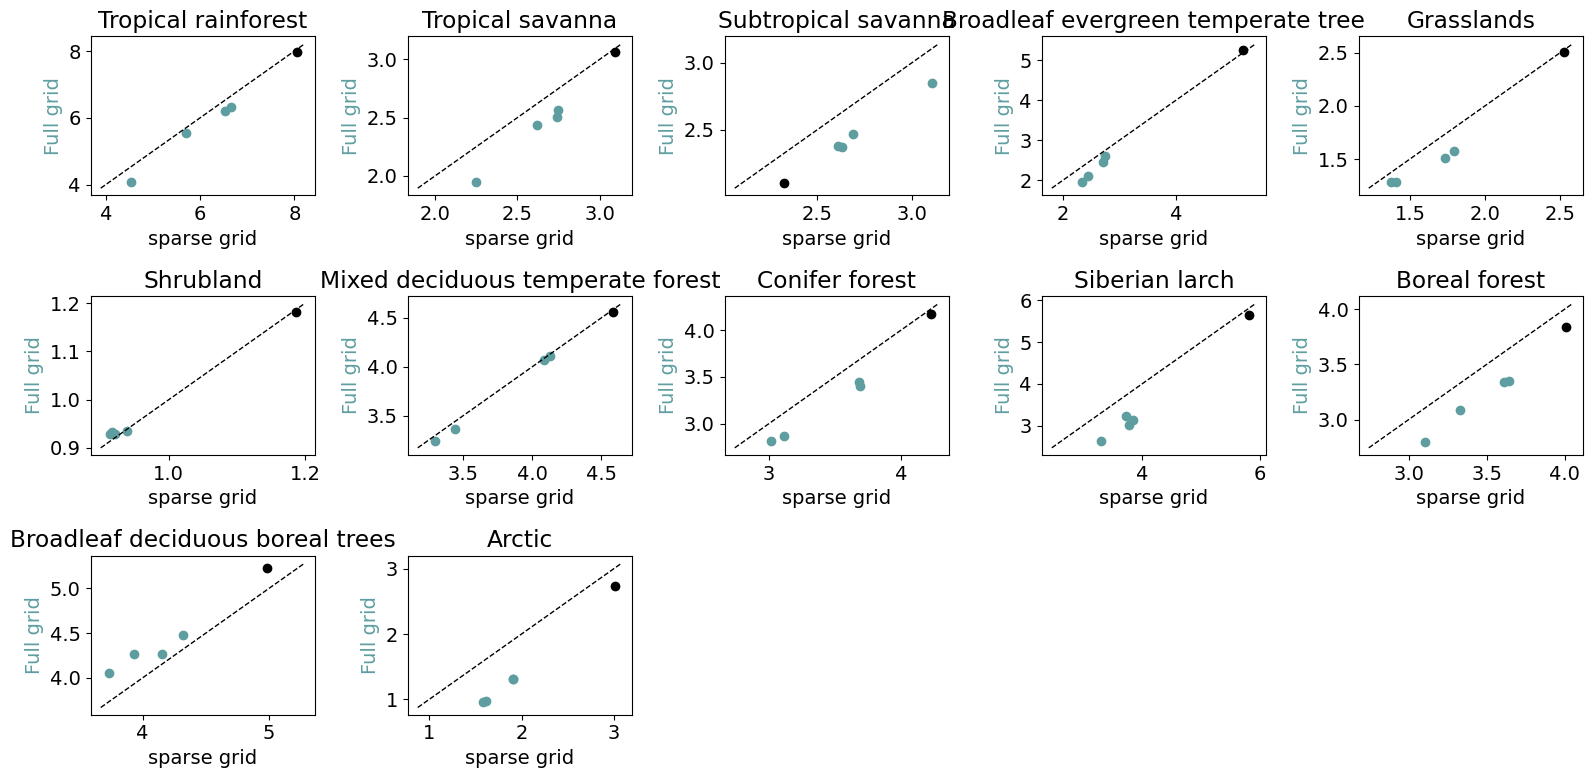

In [ ]:
plt.figure(figsize=(16, 8))
emulator_dir = '../calibration_r4/emulators_biomelai_compiled/'
set_ix = [0, 1,2,3]

for b, biome in enumerate(biome_names[1:], start=1):
    ax = plt.subplot(3, 5, b)

    # LEFT y-axis: model values
    x_cal = TLAI_biome_amax.sel(ens=set_ix).isel(biome=b).mean(dim='year')
    y_cal = fg_lai_bmean.isel(sudoku_biomes=b)
    x_def = TLAI_biome_amax_default.isel(biome=b)
    y_def = def_lai_bmean.isel(sudoku_biomes=b)

    ax.scatter(x_cal, y_cal, label='calibrated', color='cadetblue')
    ax.scatter(x_def, y_def, label='default', color='black')

    # RIGHT y-axis: emulator predictions
    #ax2 = ax.twinx()

    pfts = biome_configs[b]['pfts']
    cols = u_params
    for p in pfts:
        param_names = [f"{param}_{p}" for param in pft_params]
        cols = np.concatenate([cols, param_names])
    
    samp = df_params[cols]
    loaded_emulator = tf.saved_model.load(emulator_dir + biome)
    y_pred, y_pred_var = loaded_emulator.compiled_predict_f(samp)
    y_pred_vals = y_pred.numpy().flatten()

    # plot emulator prediction vs. x_cal on second axis
    #ax2.scatter(x_cal, y_pred_vals[:len(x_cal)], color='green', marker='x', label='emulated')

    # Identity line on left axis
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    lims = [min(xmin, ymin), max(xmax, ymax)]
    ax.plot(lims, lims, 'k--', linewidth=1)

    ymin, ymax = ax.get_ylim()
    #ax2.set_ylim(ymin, ymax)

    ax.set_title(biome_names[b])
    ax.set_ylabel('Full grid',color='cadetblue')
    #ax2.set_ylabel('Emulator prediction',color='green')
    ax.set_xlabel('sparse grid')
    #if b==1:
    #    plt.legend(loc='upper left')

plt.tight_layout()
plt.savefig('./figs/fg_v_sg_LAI_caltests89-90-92-94.png')

#### Maps of bias versus obs

In [ ]:
def plot_model_diffs(var, obs, default, full_grid, sparse_grid=None, 
                     vmin=-6, vmax=6, cmap='PRGn', savepath=None):

    fig, axes = plt.subplots(1, 3, figsize=(14, 6),
                             subplot_kw={'projection': ccrs.Robinson()})
    plt.rcParams['font.size'] = 14

    cropmask = xr.open_dataset(utils_path+'cropmask.nc')
    crop_mask = (cropmask.crop == 0)
    lf = xr.open_dataset(utils_path+'CLM-SP_amaxTLAI.nc').landfrac

    # default-obs
    ax = axes[0]
    diff = (default*lf - obs) * crop_mask.values
    rmse = np.round(np.sqrt((diff ** 2).mean()).values, 3)

    ax.coastlines()
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '110m', facecolor='white'))
    pcm = ax.pcolormesh(obs.lon, obs.lat, diff,
                        transform=ccrs.PlateCarree(), shading='auto',
                        cmap=cmap, vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(pcm, ax=ax, fraction=0.08, orientation='horizontal')
    cbar.set_label(var, size=14)
    ax.set_title('Default - Observed \n RMSE = '+str(rmse))

    # fullgrid-obs
    ax = axes[1]
    diff = (full_grid*lf - obs) * crop_mask.values
    rmse = np.round(np.sqrt((diff ** 2).mean()).values, 3)

    ax.coastlines()
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '110m', facecolor='white'))
    pcm = ax.pcolormesh(obs.lon, obs.lat, diff,
                        transform=ccrs.PlateCarree(), shading='auto',
                        cmap=cmap, vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(pcm, ax=ax, fraction=0.08, orientation='horizontal')
    cbar.set_label(var, size=14)
    ax.set_title('Tuned - Observed \n full grid I-case \n RMSE = '+str(rmse))

    # sparse grid-obs
    if sparse_grid is not None:
        ax = axes[2]
        diff = (sparse_grid*lf - obs) * crop_mask.values
        rmse = np.round(np.sqrt((diff ** 2).mean()).values, 3)
    
        ax.coastlines()
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '110m', facecolor='white'))
        pcm = ax.pcolormesh(obs.lon, obs.lat, diff,
                            transform=ccrs.PlateCarree(), shading='auto',
                            cmap=cmap, vmin=vmin, vmax=vmax)
        cbar = fig.colorbar(pcm, ax=ax, fraction=0.08, orientation='horizontal')
        cbar.set_label(var, size=14)
        ax.set_title('Tuned - Observed \n sparse grid \n RMSE = '+str(rmse))
    
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=300)
    plt.show()


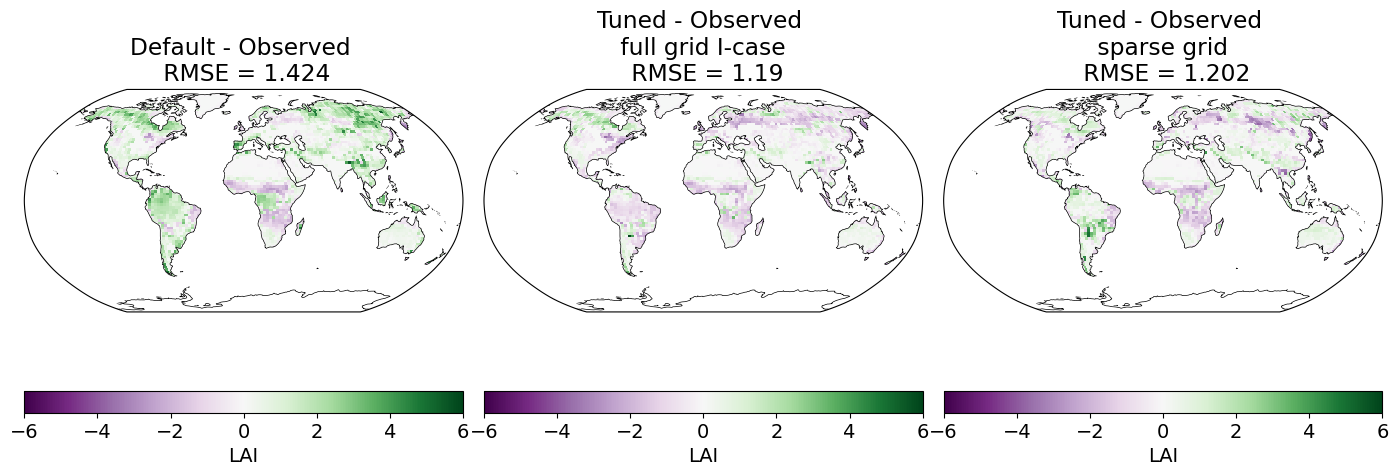

In [ ]:
e=0
savepath='../figs/cal115_fullgrid_laibias.png'
plot_model_diffs('LAI', obs.LAI, def_lai, fg_lai.isel(ens=e), sparse_grid=sg_lai.isel(ens=e), 
                     vmin=-6, vmax=6, cmap='PRGn', savepath=savepath)

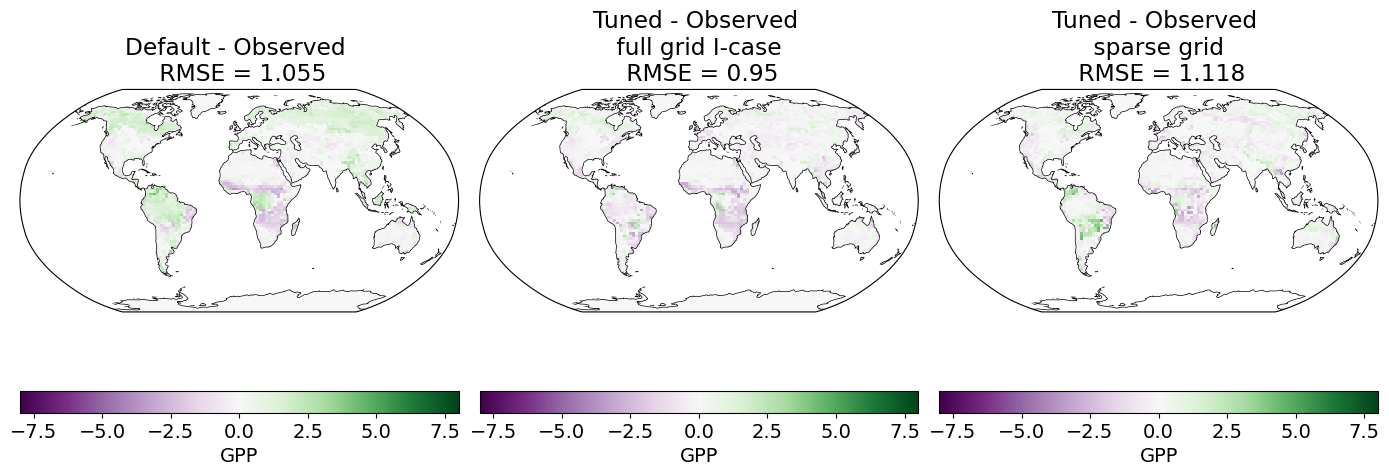

In [ ]:
e=0
savepath='../figs/cal115_fullgrid_gppbias.png'
plot_model_diffs('GPP', obs.GPP, def_gpp, fg_gpp.isel(ens=e), sg_gpp.isel(ens=e), 
                     vmin=-8, vmax=8, cmap='PRGn', savepath=savepath)

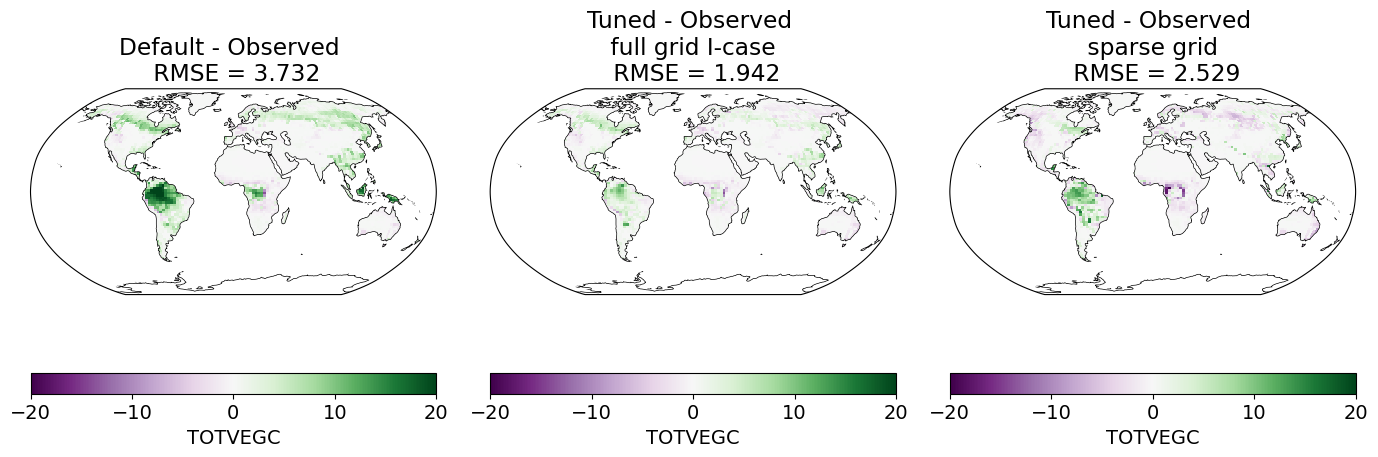

In [ ]:
e=0
savepath='../figs/cal115_fullgrid_tvcbias.png'
plot_model_diffs('TOTVEGC', obs.TOTVEGC, def_tvc, fg_tvc.isel(ens=e), sg_tvc.isel(ens=e), 
                     vmin=-20, vmax=20, cmap='PRGn', savepath=savepath)

### Scatter biome means

In [ ]:
#load LHC
key = '/glade/work/linnia/CLM6-PPE/ctsm6_lhc/ctsm6lhc_11262024.txt'
params = pd.read_csv(key).drop(columns='member')

infile = '/glade/work/linnia/CLM6-PPE/ctsm6_lhc/postp/ctsm6lhc_pxbmean_sudoku3_1985-2023.nc'
ds_lhc = xr.open_dataset(infile)

# drop crashers
lhc_pxb = ds_lhc.where(ds_lhc['crashed'] != 1, drop=True)
ix = np.where(ds_lhc.crashed==1)[0]
params_lhc = params.drop(ix-1)

lai_lhc = lhc_pxb.TLAI_biome_amax.sel(year=slice('2001','2020')).mean(dim='year').compute()
gpp_lhc = (60*60*24)*lhc_pxb.GPP_biome_amean.sel(year=slice('2001','2015')).mean(dim='year').compute()
tvc_lhc = (1/1000)*lhc_pxb.TOTVEGC_biome_amean.sel(year=slice('2000','2019')).mean(dim='year').compute()

In [ ]:
obs_biome = xr.open_dataset('../calibration_obsStatistics_sudokuBiomes.nc')

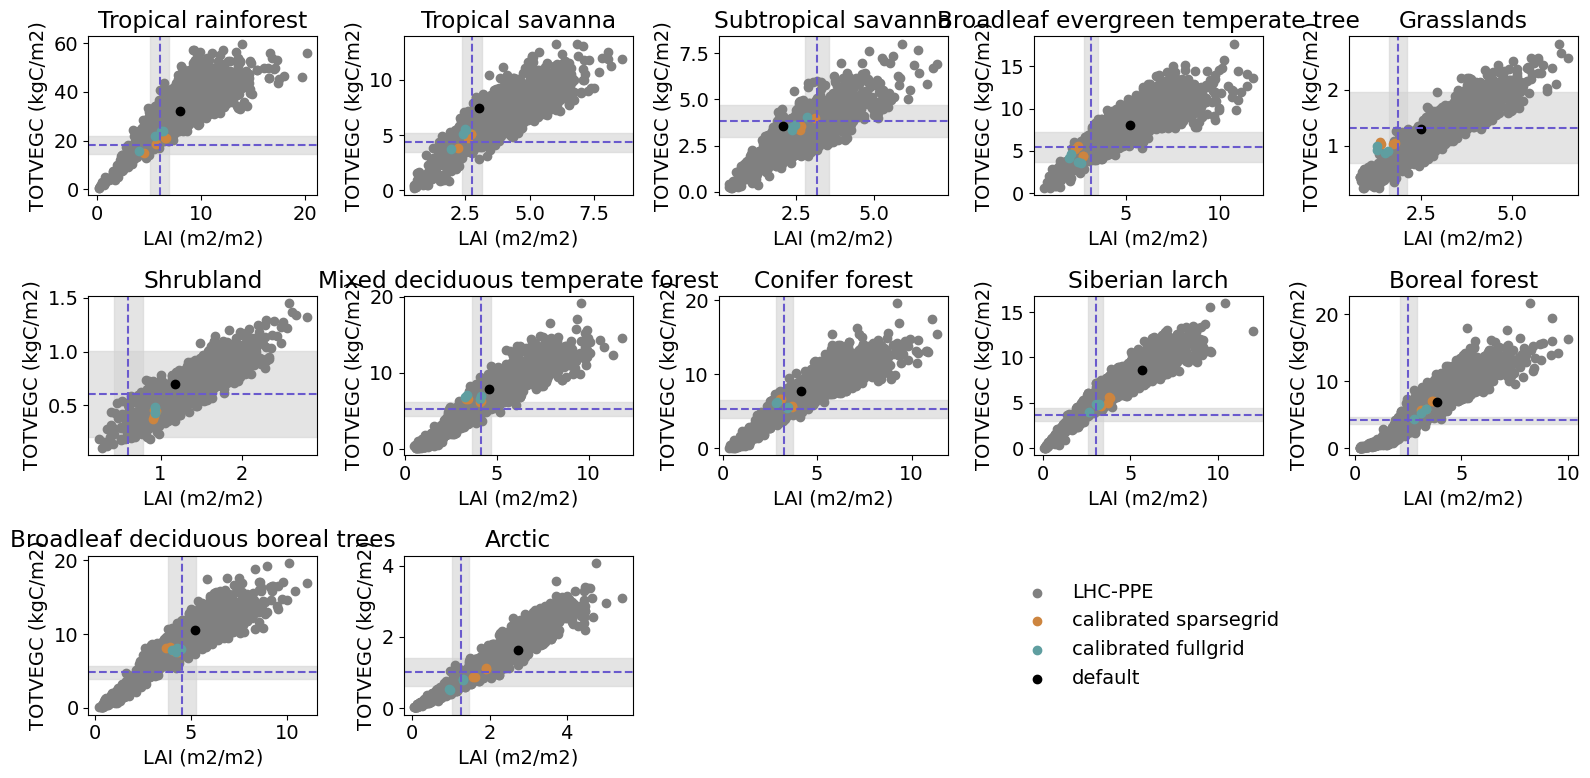

In [ ]:
plt.figure(figsize=(16, 8))
set_ix = [0, 1,2,3]

for b, biome in enumerate(biome_names[1:], start=1):
    ax = plt.subplot(3, 5, b)

    ax.axvline(obs_biome.LAI_mean.isel(biome=b), color='slateblue', linestyle='--')
    ax.axvspan(
        obs_biome.LAI_mean.isel(biome=b) - 2 * obs_biome.LAI_stdev.isel(biome=b),
        obs_biome.LAI_mean.isel(biome=b) + 2 * obs_biome.LAI_stdev.isel(biome=b),
        color='lightgrey', alpha=0.6
    )

    ax.axhline(obs_biome.TVC_mean.isel(biome=b), color='slateblue', linestyle='--')
    ax.axhspan(
        obs_biome.TVC_mean.isel(biome=b) - 2 * obs_biome.TVC_stdev.isel(biome=b),
        obs_biome.TVC_mean.isel(biome=b) + 2 * obs_biome.TVC_stdev.isel(biome=b),
        color='lightgrey', alpha=0.6
    )

    x_cal = fg_lai_bmean.isel(sudoku_biomes=b)
    y_cal = fg_tvc_bmean.isel(sudoku_biomes=b)
    x_sg = TLAI_biome_amax.isel(biome=b).mean(dim='year')
    y_sg = TVC_biome.isel(biome=b).mean(dim='year')
    x_def = def_lai_bmean.isel(sudoku_biomes=b)
    y_def = def_tvc_bmean.isel(sudoku_biomes=b)

    lhc = ax.scatter(lai_lhc.isel(biome=b), tvc_lhc.isel(biome=b), label='LHC-PPE', color='grey')
    sparsegrid = ax.scatter(x_sg, y_sg, label='calibrated sparsegrid', color='peru')
    fullgrid = ax.scatter(x_cal, y_cal, label='calibrated fullgrid', color='cadetblue')
    default = ax.scatter(x_def, y_def, label='default', color='black')

    ax.set_title(biome_names[b])
    ax.set_xlabel('LAI (m2/m2)')
    ax.set_ylabel('TOTVEGC (kgC/m2)')


legend_ax = plt.subplot(3, 5, 14)
legend_ax.axis('off')
legend_ax.legend(
    handles=[lhc, sparsegrid, fullgrid, default],
    labels=['LHC-PPE', 'calibrated sparsegrid', 'calibrated fullgrid', 'default'],
    loc='center',
    frameon=False
)

plt.tight_layout()
#plt.savefig('scatter_lai_tvc_lhc_fg_sg_caltests.png', dpi=300)


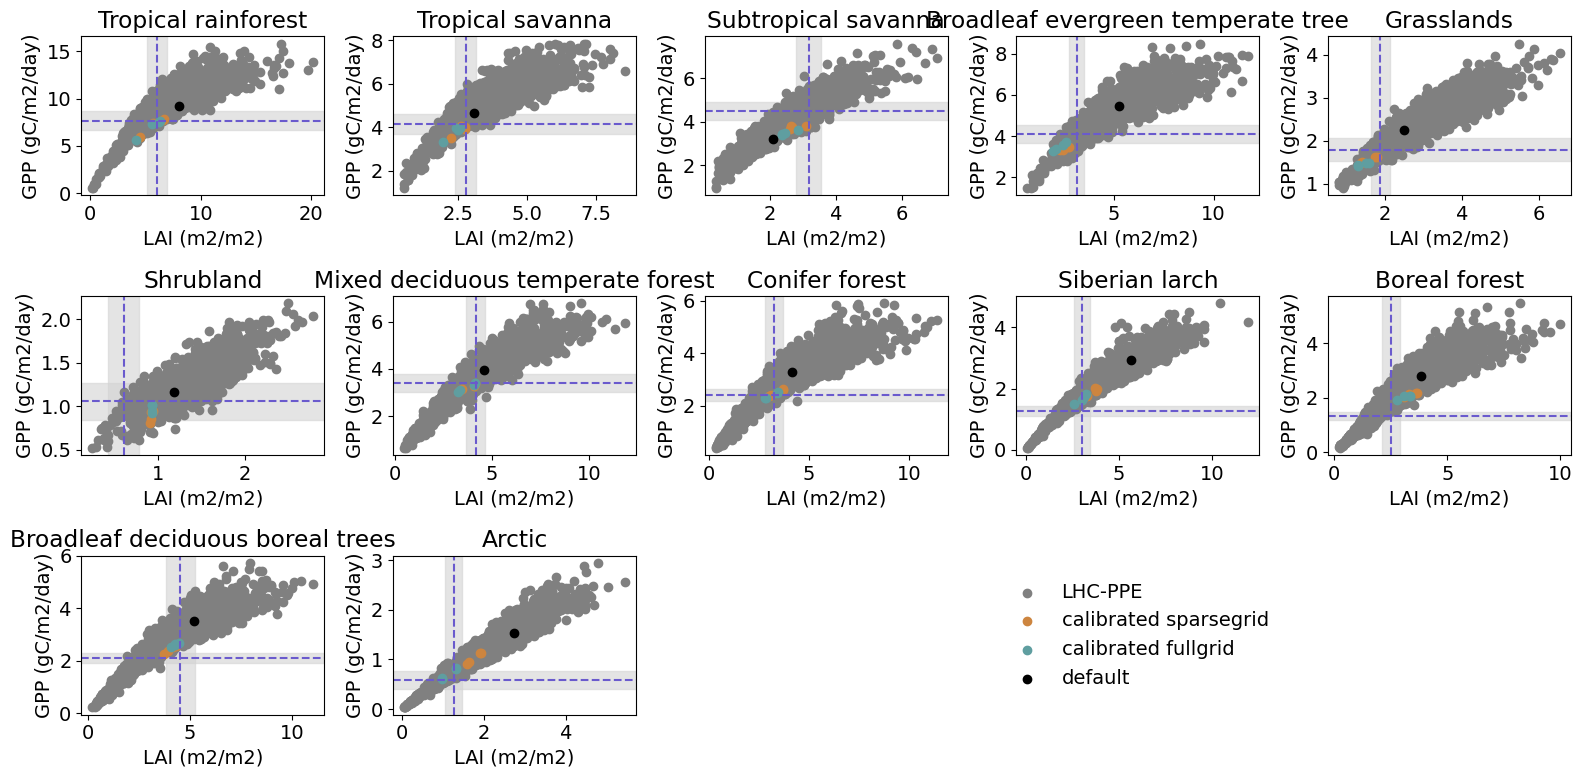

In [ ]:
plt.figure(figsize=(16, 8))
set_ix = [0, 1,2,3]

for b, biome in enumerate(biome_names[1:], start=1):
    ax = plt.subplot(3, 5, b)

    ax.axvline(obs_biome.LAI_mean.isel(biome=b), color='slateblue', linestyle='--')
    ax.axvspan(
        obs_biome.LAI_mean.isel(biome=b) - 2 * obs_biome.LAI_stdev.isel(biome=b),
        obs_biome.LAI_mean.isel(biome=b) + 2 * obs_biome.LAI_stdev.isel(biome=b),
        color='lightgrey', alpha=0.6
    )

    ax.axhline(obs_biome.GPP_mean.isel(biome=b), color='slateblue', linestyle='--')
    ax.axhspan(
        obs_biome.GPP_mean.isel(biome=b) - 2 * obs_biome.GPP_stdev.isel(biome=b),
        obs_biome.GPP_mean.isel(biome=b) + 2 * obs_biome.GPP_stdev.isel(biome=b),
        color='lightgrey', alpha=0.6
    )

    x_cal = fg_lai_bmean.isel(sudoku_biomes=b)
    y_cal = fg_gpp_bmean.isel(sudoku_biomes=b)
    x_sg = TLAI_biome_amax.sel(ens=set_ix).isel(biome=b).mean(dim='year')
    y_sg = GPP_biome.sel(ens=set_ix).isel(biome=b).mean(dim='year')
    x_def = def_lai_bmean.isel(sudoku_biomes=b)
    y_def = def_gpp_bmean.isel(sudoku_biomes=b)

    lhc = ax.scatter(lai_lhc.isel(biome=b), gpp_lhc.isel(biome=b), label='LHC-PPE', color='grey')
    sparsegrid = ax.scatter(x_sg, y_sg, label='calibrated sparsegrid', color='peru')
    fullgrid = ax.scatter(x_cal, y_cal, label='calibrated fullgrid', color='cadetblue')
    default = ax.scatter(x_def, y_def, label='default', color='black')

    ax.set_title(biome_names[b])
    ax.set_xlabel('LAI (m2/m2)')
    ax.set_ylabel('GPP (gC/m2/day)')


legend_ax = plt.subplot(3, 5, 14)
legend_ax.axis('off')
legend_ax.legend(
    handles=[lhc, sparsegrid, fullgrid, default],
    labels=['LHC-PPE', 'calibrated sparsegrid', 'calibrated fullgrid', 'default'],
    loc='center',
    frameon=False
)

plt.tight_layout()
#plt.savefig('scatter_lai_gpp_lhc_fg_sg_caltests.png', dpi=300)

### whats up with crops?

In [9]:
import xarray as xr


def amean(da):
    #annual mean of monthly data
    m  = da['time.daysinmonth']
    cf = 1/365
    xa = cf*(m*da).groupby('time.year').sum().compute()
    return xa

in_file = '/glade/derecho/scratch/wwieder/ADF_unstruct/ctsm5.4_5.3.068_PPEcal115_116_HIST/ts'

In [10]:
in_file = '/glade/derecho/scratch/wwieder/ADF_unstruct/ctsm5.4_5.3.068_PPEcal115_116_HIST/ts/ctsm5.4_5.3.068_PPEcal115_116_HIST.clm2.h0a.TOTSOMC_1m.185001-202312.nc'
# The 'parse_dates' argument is not valid for xr.open_dataset and will cause an error.
# If you want to ensure time is decoded, use decode_times=True (which is the default).
somc_116 = xr.open_dataset(in_file,decode_times=True)

In [11]:
da = amean(somc_116.TOTSOMC_1m)
la = somc_116.area*somc_116.landfrac
x=(da*la).sum(dim='lndgrid')/la.sum()
cf = 1E-9*la.sum()
gmean_somc = (x * cf)

In [31]:
# finite volume 2degree cal115 simulation
la = (master_ds.area*master_ds.landfrac).isel(ens=0)
fg_somc = amean(master_ds.TOTSOMC_1m)
tmp = gmean(fg_somc.squeeze(),la).mean(dim='time')
fg_somc_gmean = 1E-9*la.sum()*tmp

In [35]:
fg_somc_gmean.plot(label='BGC-nocrop 2degree')
gmean_somc.plot(label='BGC-CROP ne30')
plt.legend()
plt.ylabel('PgC')

RuntimeError: NetCDF: Not a valid ID